In [1]:
import os
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

In [2]:
data = pd.read_csv("bs140513_032310.csv")
data.head(5)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [3]:
data.shape

(594643, 10)

In [4]:
data.head(10)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0
5,0,'C1315400589','3','F','28007','M348934600','28007','es_transportation',25.81,0
6,0,'C765155274','1','F','28007','M348934600','28007','es_transportation',9.10,0
7,0,'C202531238','4','F','28007','M348934600','28007','es_transportation',21.17,0
8,0,'C105845174','3','M','28007','M348934600','28007','es_transportation',32.40,0
9,0,'C39858251','5','F','28007','M348934600','28007','es_transportation',35.40,0


In [5]:
data.isnull().sum()

step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
dtype: int64

In [6]:
data.describe(include='all')

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
count,594643.000000,594643,594643,594643,594643,594643,594643,594643,594643.000000,594643.000000
unique,NaN,4112,8,4,1,50,1,15,NaN,NaN
top,NaN,'C1978250683','2','F','28007','M1823072687','28007','es_transportation',NaN,NaN
freq,NaN,265,187310,324565,594643,299693,594643,505119,NaN,NaN
mean,94.986827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.890135,0.012108
std,51.053632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111.402831,0.109369
min,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,52.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.740000,0.000000
50%,97.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.900000,0.000000
75%,139.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.540000,0.000000


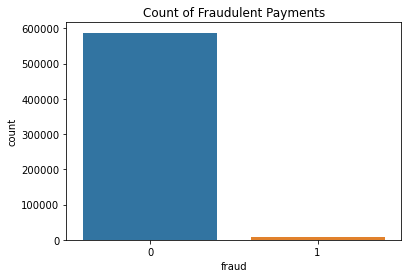

Number of normal examples:  587443
Number of fradulent examples:  7200


In [7]:
# Create two dataframes with fraud and non-fraud data 
df_fraud = data.loc[data.fraud == 1] 
df_non_fraud = data.loc[data.fraud == 0]

sns.countplot(x="fraud",data=data)
plt.title("Count of Fraudulent Payments")
plt.show()
print("Number of normal examples: ",df_non_fraud.fraud.count())
print("Number of fradulent examples: ",df_fraud.fraud.count())

In [8]:
# Create two dataframes with fraud and non-fraud data 
pd.concat([df_fraud.groupby('category')['amount'].mean(),df_non_fraud.groupby('category')['amount'].mean(),\
           data.groupby('category')['fraud'].mean()*100],keys=["Fraudulent","Non-Fraudulent","Percent(%)"],axis=1,\
          sort=False).sort_values(by=['Non-Fraudulent'])

,Fraudulent,Non-Fraudulent,Percent(%)
category,,,
'es_transportation',NaN,26.958187,0.000000
'es_food',NaN,37.070405,0.000000
'es_hyper',169.255429,40.037145,4.591669
'es_barsandrestaurants',164.092667,41.145997,1.882944
'es_contents',NaN,44.547571,0.000000
'es_wellnessandbeauty',229.422535,57.320219,4.759380
'es_fashion',247.008190,62.347674,1.797335
'es_leisure',300.286878,73.230400,94.989980
'es_otherservices',316.469605,75.685497,25.000000


In [9]:
pd.concat([df_fraud.groupby('customer')['amount'].mean(),df_non_fraud.groupby('customer')['amount'].mean(),\
           data.groupby('customer')['fraud'].mean()*100],keys=["Fraudulent","Non-Fraudulent","Percent(%)"],axis=1,\
          sort=False).sort_values(by=['Non-Fraudulent'])

,Fraudulent,Non-Fraudulent,Percent(%)
customer,,,
'C400803731',NaN,23.372024,0.000000
'C1612832553',397.363333,24.230612,2.970297
'C1480064437',NaN,24.512465,0.000000
'C923543549',NaN,24.703929,0.000000
'C1546864044',NaN,24.928929,0.000000
...,...,...,...
'C2137381129',218.802500,136.350909,26.666667
'C1233811793',210.912000,142.375000,71.428571
'C1204835011',355.347500,143.056250,33.333333


In [10]:
pd.concat([df_fraud.groupby('merchant')['amount'].mean(),df_non_fraud.groupby('merchant')['amount'].mean(),\
           data.groupby('merchant')['fraud'].mean()*100],keys=["Fraudulent","Non-Fraudulent","Percent(%)"],axis=1,\
          sort=False).sort_values(by=['Non-Fraudulent'])

,Fraudulent,Non-Fraudulent,Percent(%)
merchant,,,
'M1823072687',NaN,26.953146,0.000000
'M348934600',NaN,26.965542,0.000000
'M85975013',NaN,37.070405,0.000000
'M855959430',169.255429,40.037145,4.591669
'M151143676',164.092667,41.145997,1.882944
'M677738360',NaN,44.479832,0.000000
'M1313686961',NaN,44.593586,0.000000
'M97925176',NaN,56.637796,0.000000
'M1198415165',223.999525,56.720434,22.658228


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


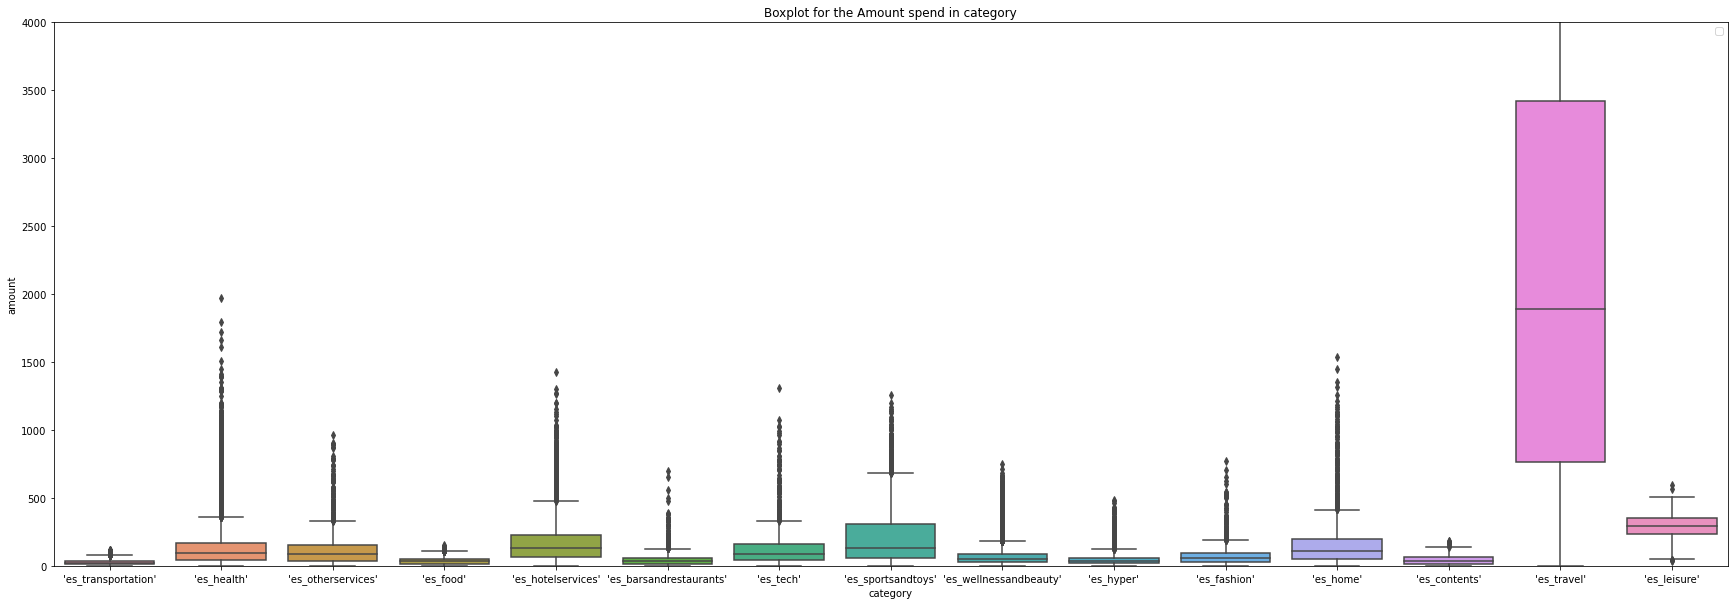

In [11]:
plt.figure(figsize=(30,10))
sns.boxplot(x=data.category,y=data.amount)
plt.title("Boxplot for the Amount spend in category")
plt.ylim(0,4000)
plt.legend()
plt.show()

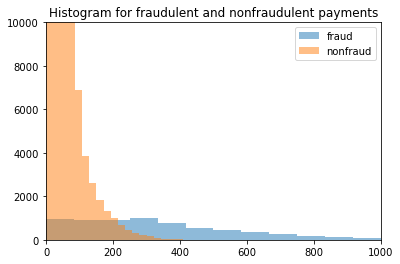

In [12]:
plt.hist(df_fraud.amount, alpha=0.5, label='fraud',bins=100)
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud',bins=100)
plt.title("Histogram for fraudulent and nonfraudulent payments")
plt.ylim(0,10000)
plt.xlim(0,1000)
plt.legend()
plt.show()

In [13]:
print((data.groupby('age')['fraud'].mean()*100).reset_index().rename(columns={'age':'Age','fraud' : 'Fraud Percent'}).sort_values(by='Fraud Percent'))

   Age  Fraud Percent
7  'U'       0.594228
6  '6'       0.974826
5  '5'       1.095112
1  '1'       1.185254
3  '3'       1.192815
2  '2'       1.251401
4  '4'       1.293281
0  '0'       1.957586


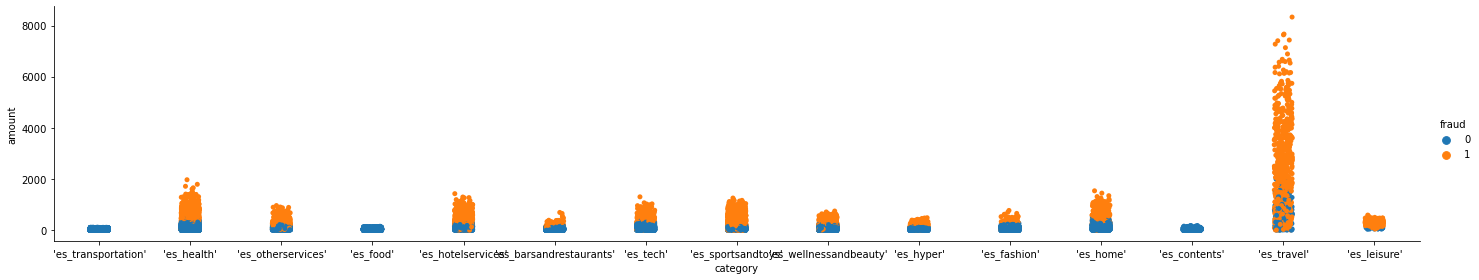

In [14]:
ax = sns.catplot(x="category", y="amount", hue="fraud", data=data, height=4, aspect=5)

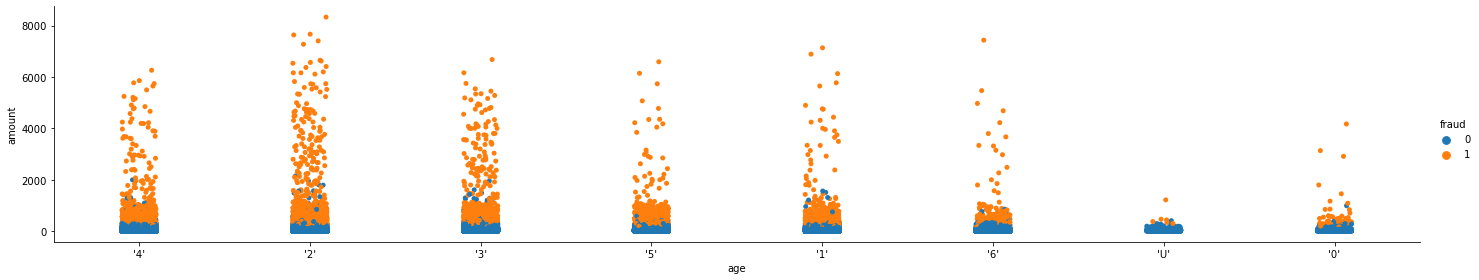

In [15]:
ax = sns.catplot(x="age", y="amount", hue="fraud", data=data, height=4, aspect=5)

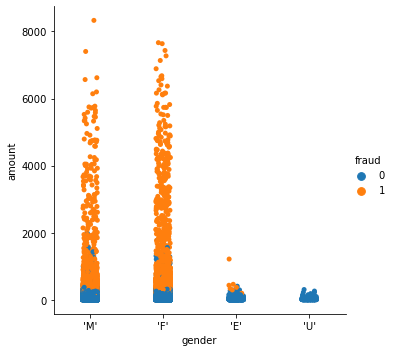

In [16]:
ax = sns.catplot(x="gender", y="amount", hue="fraud", data=data)

In [17]:
print("Unique zipCodeOri values: ",data.zipcodeOri.nunique())
print("Unique zipMerchant values: ",data.zipMerchant.nunique())
# dropping zipcodeori and zipMerchant since they have only one unique value
data_reduced = data.drop(['zipcodeOri','zipMerchant'],axis=1)

Unique zipCodeOri values:  1
Unique zipMerchant values:  1


In [18]:
data_reduced.columns

Index(['step', 'customer', 'age', 'gender', 'merchant', 'category', 'amount',
       'fraud'],
      dtype='object')

In [19]:
# turning object columns type to categorical for easing the transformation process
col_categorical = data_reduced.select_dtypes(include= ['object']).columns
for col in col_categorical:
    data_reduced[col] = data_reduced[col].astype('category')
# categorical values ==> numeric values
data_reduced[col_categorical] = data_reduced[col_categorical].apply(lambda x: x.cat.codes)
data_reduced.head(5)

,step,customer,age,gender,merchant,category,amount,fraud
0,0,210,4,2,30,12,4.55,0
1,0,2753,2,2,30,12,39.68,0
2,0,2285,4,1,18,12,26.89,0
3,0,1650,3,2,30,12,17.25,0
4,0,3585,5,2,30,12,35.72,0


C:\Users\AAA\AppData\Local\Temp\ipykernel_11544\1251524294.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(200,10,as_cmap=True),


<AxesSubplot:>

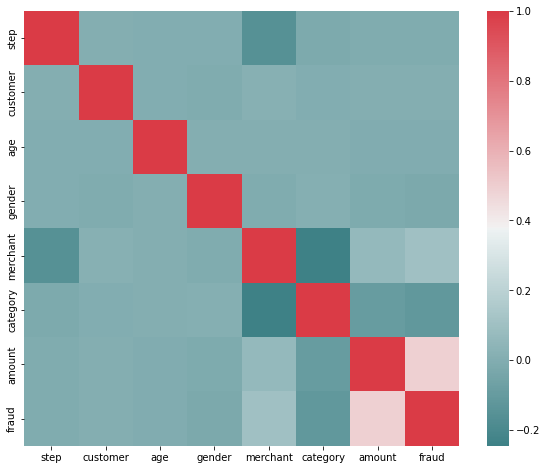

In [20]:
fi, axis = plt.subplots(figsize=(10, 8))
corr = data_reduced.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(200,10,as_cmap=True), 
           square=True, ax=axis)

array([[<AxesSubplot:title={'center':'step'}>,
        <AxesSubplot:title={'center':'customer'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'gender'}>,
        <AxesSubplot:title={'center':'merchant'}>,
        <AxesSubplot:title={'center':'category'}>],
       [<AxesSubplot:title={'center':'amount'}>,
        <AxesSubplot:title={'center':'fraud'}>, <AxesSubplot:>]],
      dtype=object)

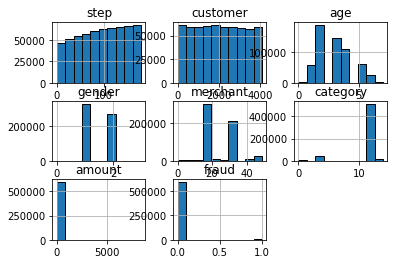

In [21]:
data_reduced.hist(edgecolor='black')

In [22]:
# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(data_reduced, data_reduced.fraud, test_size=0.3, random_state=42)

#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(x_train,y_train)

from sklearn.feature_selection import RFE
# Create the RFE object and rank each pixel
clf_rf_3 = RandomForestClassifier()      
rfe = RFE(estimator=clf_rf_3, n_features_to_select=3, step=1)
rfe = rfe.fit(x_train, y_train)

print('Best features:',x_train.columns[rfe.support_])

Best features: Index(['merchant', 'amount', 'fraud'], dtype='object')


In [23]:
X = data_reduced.drop(['fraud'],axis=1)
y = data['fraud']
print(y[y==1].count())

7200


In [43]:
df_hist = pd.DataFrame(index = range_amount)
df_hist.index.name = 'Transaction Amount[$]'
df_hist['# Total'] = n
df_hist['# Frauds'] = n_fraud
df_hist['# Safe'] = df_hist['# Total'] - df_hist['# Frauds']
df_hist['% Frauds'] = (df_hist['# Frauds'] / df_hist['# Total'] * 100).round(2)
df_hist['% Safe'] = (df_hist['# Safe'] / df_hist['# Total'] * 100).round(2)
df_hist

,# Total,# Frauds,# Safe,% Frauds,% Safe
Transaction Amount[$],,,,,
$ 0 ~ 832,593762.0,6367.0,587395.0,1.07,98.93
$ 832 ~ 1665,483.0,441.0,42.0,91.30,8.70
$ 1665 ~ 2498,118.0,112.0,6.0,94.92,5.08
$ 2498 ~ 3331,87.0,87.0,0.0,100.00,0.00
$ 3331 ~ 4164,72.0,72.0,0.0,100.00,0.00
$ 4164 ~ 4997,62.0,62.0,0.0,100.00,0.00
$ 4997 ~ 5830,34.0,34.0,0.0,100.00,0.00
$ 5830 ~ 6663,16.0,16.0,0.0,100.00,0.00
$ 6663 ~ 7496,6.0,6.0,0.0,100.00,0.00


In [44]:
print("Percentage of frauds: ", frauds/total_obs*100)
print("Percentage of no frauds: ", no_frauds/total_obs*100)

Percentage of frauds:  1.2108105199254007
Percentage of no frauds:  98.7891894800746


In [24]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
y_res = pd.DataFrame(y_res)

In [25]:
# %% Function for plotting ROC_AUC curve

def plot_roc_auc(y_test, preds):
    '''
    Takes actual and predicted(probabilities) as input and plots the Receiver
    Operating Characteristic (ROC) curve
    '''
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.3,random_state=42,shuffle=True,stratify=y_res)

In [27]:
# The base score should be better than predicting always non-fraduelent
print("Base accuracy score we must beat is: ", 
      df_non_fraud.fraud.count()/ np.add(df_non_fraud.fraud.count(),df_fraud.fraud.count()) * 100)

Base accuracy score we must beat is:  98.7891894800746


C:\Users\AAA\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Classification Report for K-Nearest Neighbours: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    176233
           1       0.98      1.00      0.99    176233

    accuracy                           0.99    352466
   macro avg       0.99      0.99      0.99    352466
weighted avg       0.99      0.99      0.99    352466

Confusion Matrix of K-Nearest Neigbours: 
 [[171999   4234]
 [   362 175871]]


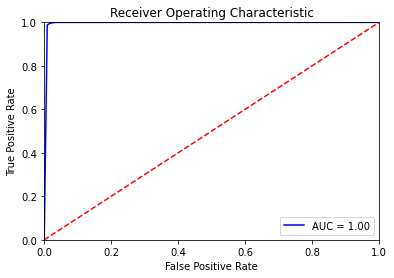

In [28]:
# %% K-ello Neigbors

knn = KNeighborsClassifier(n_neighbors=5,p=1)

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)


print("Classification Report for K-Nearest Neighbours: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of K-Nearest Neigbours: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, knn.predict_proba(X_test)[:,1])

C:\Users\AAA\AppData\Local\Temp\ipykernel_11544\2368093465.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(X_train,y_train)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.1s finished


Classification Report for Random Forest Classifier: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98    176233
           1       0.97      0.99      0.98    176233

    accuracy                           0.98    352466
   macro avg       0.98      0.98      0.98    352466
weighted avg       0.98      0.98      0.98    352466

Confusion Matrix of Random Forest Classifier: 
 [[170106   6127]
 [  1079 175154]]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.0s finished


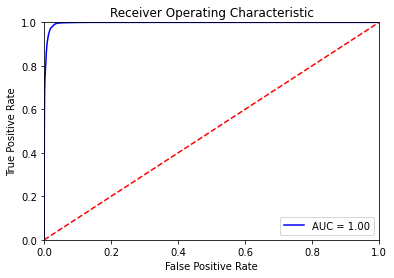

In [29]:
# %% Random Forest Classifier

rf_clf = RandomForestClassifier(n_estimators=100,max_depth=8,random_state=42,
                                verbose=1,class_weight="balanced")

rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)

print("Classification Report for Random Forest Classifier: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of Random Forest Classifier: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, rf_clf.predict_proba(X_test)[:,1])

[20:51:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Classification Report for XGBoost: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    176233
           1       0.99      1.00      0.99    176233

    accuracy                           0.99    352466
   macro avg       0.99      0.99      0.99    352466
weighted avg       0.99      0.99      0.99    352466

Confusion Matrix of XGBoost: 
 [[174047   2186]
 [   706 175527]]


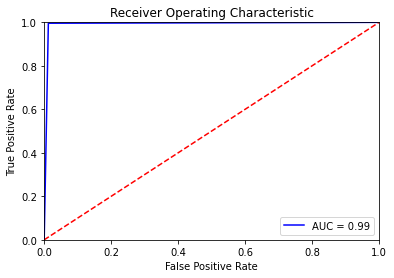

In [30]:
XGBoost_CLF = xgb.XGBClassifier(max_depth=6, learning_rate=0.05, n_estimators=400, 
                                objective="binary:hinge", booster='gbtree', 
                                n_jobs=-1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, 
                                subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                                scale_pos_weight=1, base_score=0.5, random_state=42, verbosity=1)

XGBoost_CLF.fit(X_train,y_train)

y_pred = XGBoost_CLF.predict(X_test)

print("Classification Report for XGBoost: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of XGBoost: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, XGBoost_CLF.predict_proba(X_test)[:,1])

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    random_state=42,
    test_size=0.3)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test,
    random_state=42,
    test_size=0.3)

print(f'Training set: {X_train.shape}, {y_train.shape}')
print(f'Validation set: {X_valid.shape}, {y_valid.shape}')
print(f'Test set: {X_test.shape}, {y_test.shape}')

Training set: (416250, 7), (416250,)
Validation set: (124875, 7), (124875,)
Test set: (53518, 7), (53518,)


In [32]:
model = KNeighborsClassifier(n_neighbors=5,p=1)
model = model.fit(X_train, y_train)

In [33]:
y_hat_train = model.predict(X_train)
y_hat_valid = model.predict(X_valid)
y_hat_test = model.predict(X_test)

K Neighbors Classifier
Training Set
[[410770    396]
 [  1739   3345]]
Accuracy: 0.995
Precision: 0.894
Recall: 0.658
F1-score: 0.758

Validation Set
[[123221    168]
 [   563    923]]
Accuracy: 0.994
Precision: 0.846
Recall: 0.621
F1-score: 0.716

Test Set
Accuracy: 0.994
Precision: 0.849
Recall: 0.600
F1-score: 0.703


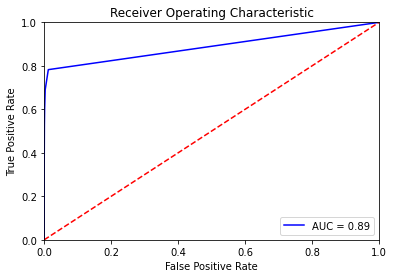

In [34]:
print('K Neighbors Classifier')
print('Training Set')
print(confusion_matrix(y_true=y_train, y_pred=y_hat_train))
print(f'Accuracy: {accuracy_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print(f'Precision: {precision_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print(f'Recall: {recall_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print(f'F1-score: {f1_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print('')
print('Validation Set')
print(confusion_matrix(y_true=y_valid, y_pred=y_hat_valid))
print(f'Accuracy: {accuracy_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print(f'Precision: {precision_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print(f'Recall: {recall_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print(f'F1-score: {f1_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print('\nTest Set')
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_hat_test):.3f}')
print(f'Precision: {precision_score(y_true=y_test, y_pred=y_hat_test):.3f}')
print(f'Recall: {recall_score(y_true=y_test, y_pred=y_hat_test):.3f}')
print(f'F1-score: {f1_score(y_true=y_test, y_pred=y_hat_test):.3f}')
plot_roc_auc(y_test, model.predict_proba(X_test)[:,1])

In [35]:
model = RandomForestClassifier(n_estimators=100,max_depth=8,random_state=42,verbose=1,class_weight="balanced")
model = model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   32.3s finished


In [36]:
y_hat_train = model.predict(X_train)
y_hat_valid = model.predict(X_valid)
y_hat_test = model.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


Random Forest Classifier
Training Set
[[395164  16002]
 [    45   5039]]
Accuracy: 0.961
Precision: 0.239
Recall: 0.991
F1-score: 0.386

Validation Set
[[118630   4759]
 [    16   1470]]
Accuracy: 0.962
Precision: 0.236
Recall: 0.989
F1-score: 0.381

Test Set
Accuracy: 0.961
Precision: 0.231
Recall: 0.976
F1-score: 0.373


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


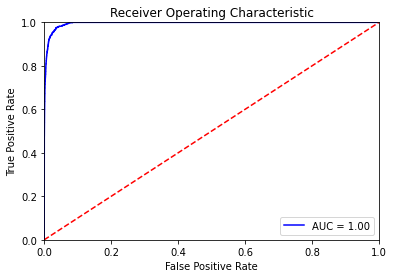

In [37]:
print('Random Forest Classifier')
print('Training Set')
print(confusion_matrix(y_true=y_train, y_pred=y_hat_train))
print(f'Accuracy: {accuracy_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print(f'Precision: {precision_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print(f'Recall: {recall_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print(f'F1-score: {f1_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print('')
print('Validation Set')
print(confusion_matrix(y_true=y_valid, y_pred=y_hat_valid))
print(f'Accuracy: {accuracy_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print(f'Precision: {precision_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print(f'Recall: {recall_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print(f'F1-score: {f1_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print('\nTest Set')
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_hat_test):.3f}')
print(f'Precision: {precision_score(y_true=y_test, y_pred=y_hat_test):.3f}')
print(f'Recall: {recall_score(y_true=y_test, y_pred=y_hat_test):.3f}')
print(f'F1-score: {f1_score(y_true=y_test, y_pred=y_hat_test):.3f}')
plot_roc_auc(y_test, model.predict_proba(X_test)[:,1])

In [38]:
model = XGBoost_CLF = xgb.XGBClassifier(max_depth=6, learning_rate=0.05, n_estimators=400, 
                                objective="binary:hinge", booster='gbtree', 
                                n_jobs=-1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, 
                                subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                                scale_pos_weight=1, base_score=0.5, random_state=42, verbosity=1)
model = model.fit(X_train, y_train)

[20:54:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [39]:
y_hat_train = model.predict(X_train)
y_hat_valid = model.predict(X_valid)
y_hat_test = model.predict(X_test)

XGBoost
Training Set
[[410866    300]
 [  1059   4025]]
Accuracy: 0.997
Precision: 0.931
Recall: 0.792
F1-score: 0.856

Validation Set
[[123273    116]
 [   326   1160]]
Accuracy: 0.996
Precision: 0.909
Recall: 0.781
F1-score: 0.840

Test Set
Accuracy: 0.996
Precision: 0.903
Recall: 0.738
F1-score: 0.812


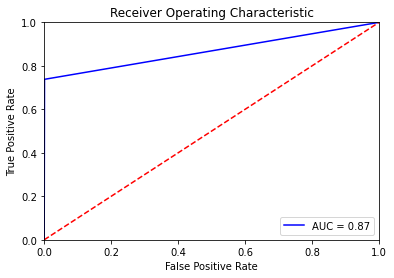

In [40]:
print('XGBoost')
print('Training Set')
print(confusion_matrix(y_true=y_train, y_pred=y_hat_train))
print(f'Accuracy: {accuracy_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print(f'Precision: {precision_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print(f'Recall: {recall_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print(f'F1-score: {f1_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print('')
print('Validation Set')
print(confusion_matrix(y_true=y_valid, y_pred=y_hat_valid))
print(f'Accuracy: {accuracy_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print(f'Precision: {precision_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print(f'Recall: {recall_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print(f'F1-score: {f1_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print('\nTest Set')
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_hat_test):.3f}')
print(f'Precision: {precision_score(y_true=y_test, y_pred=y_hat_test):.3f}')
print(f'Recall: {recall_score(y_true=y_test, y_pred=y_hat_test):.3f}')
print(f'F1-score: {f1_score(y_true=y_test, y_pred=y_hat_test):.3f}')
plot_roc_auc(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['fraud','true'],normalize= False,  title='Confusion matrix')

In [41]:
is_fraud, not_fraud = data[data['fraud'] == 1], data[data['fraud'] == 0]
frauds = len(is_fraud)
no_frauds = len(not_fraud)
total_obs = len(data)

In [42]:
num_bins = 10
tran_amount = data['amount']
n, bins, patches = plt.hist(tran_amount, num_bins, stacked = True, facecolor= '#f26a6a', alpha=0.5)
plt.close()
n_fraud = np.zeros(num_bins)
for i in range(num_bins):
    for j in range(frauds):
        if bins[i] < is_fraud['amount'].iloc[j] <= bins[i+1]:
            n_fraud[i] += 1
range_amount = []
for i in range(num_bins):
    lower_lim, higher_lim = str(int(bins[i])), str(int(bins[i+1]))
    range_amount.append("$ " + lower_lim + " ~ " + higher_lim )

For Test Part

In [45]:
scaler = RobustScaler()
scaler.fit(X_train)
s_X_train = scaler.transform(X_train)
model = RandomForestClassifier(n_estimators=100,max_depth=8,random_state=42,
                                verbose=1,class_weight="balanced")
model = model.fit(s_X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   31.6s finished


In [46]:
y_hat_train = model.predict(s_X_train)
s_X_valid = scaler.transform(X_valid)
y_hat_valid = model.predict(s_X_valid)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished


Random with RobustScaler
Training Set
[[395164  16002]
 [    45   5039]]
Accuracy: 0.961
Precision: 0.239
Recall: 0.991
F1-score: 0.386

Validation Set
[[118630   4759]
 [    16   1470]]
Accuracy: 0.962
Precision: 0.236
Recall: 0.989
F1-score: 0.381

Test Set
Accuracy: 0.996
Precision: 0.903
Recall: 0.738
F1-score: 0.812


C:\Users\AAA\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


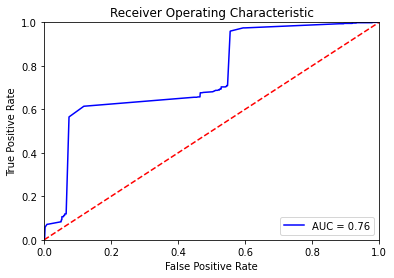

In [47]:
print('Random with RobustScaler')
print('Training Set')
print(confusion_matrix(y_true=y_train, y_pred=y_hat_train))
print(f'Accuracy: {accuracy_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print(f'Precision: {precision_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print(f'Recall: {recall_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print(f'F1-score: {f1_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print('')
print('Validation Set')
print(confusion_matrix(y_true=y_valid, y_pred=y_hat_valid))
print(f'Accuracy: {accuracy_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print(f'Precision: {precision_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print(f'Recall: {recall_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print(f'F1-score: {f1_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print('\nTest Set')
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_hat_test):.3f}')
print(f'Precision: {precision_score(y_true=y_test, y_pred=y_hat_test):.3f}')
print(f'Recall: {recall_score(y_true=y_test, y_pred=y_hat_test):.3f}')
print(f'F1-score: {f1_score(y_true=y_test, y_pred=y_hat_test):.3f}')
plot_roc_auc(y_test, model.predict_proba(X_test)[:,1])

In [48]:
scaler = MinMaxScaler()
scaler.fit(X_train)
s_X_train = scaler.transform(X_train)
model = RandomForestClassifier(n_estimators=100,max_depth=8,random_state=42,
                                verbose=1,class_weight="balanced")
model = model.fit(s_X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   31.9s finished


In [49]:
y_hat_train = model.predict(s_X_train)
s_X_valid = scaler.transform(X_valid)
y_hat_valid = model.predict(s_X_valid)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished


Random with MinMaxScaler
Training Set
[[395164  16002]
 [    45   5039]]
Accuracy: 0.961
Precision: 0.239
Recall: 0.991
F1-score: 0.386

Validation Set
[[118630   4759]
 [    16   1470]]
Accuracy: 0.962
Precision: 0.236
Recall: 0.989
F1-score: 0.381

Test Set
Accuracy: 0.996
Precision: 0.903
Recall: 0.738
F1-score: 0.812


C:\Users\AAA\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


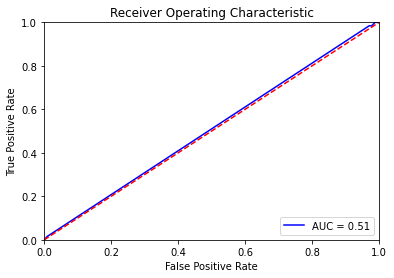

In [50]:
print('Random with MinMaxScaler')
print('Training Set')
print(confusion_matrix(y_true=y_train, y_pred=y_hat_train))
print(f'Accuracy: {accuracy_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print(f'Precision: {precision_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print(f'Recall: {recall_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print(f'F1-score: {f1_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print('')
print('Validation Set')
print(confusion_matrix(y_true=y_valid, y_pred=y_hat_valid))
print(f'Accuracy: {accuracy_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print(f'Precision: {precision_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print(f'Recall: {recall_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print(f'F1-score: {f1_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print('\nTest Set')
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_hat_test):.3f}')
print(f'Precision: {precision_score(y_true=y_test, y_pred=y_hat_test):.3f}')
print(f'Recall: {recall_score(y_true=y_test, y_pred=y_hat_test):.3f}')
print(f'F1-score: {f1_score(y_true=y_test, y_pred=y_hat_test):.3f}')
plot_roc_auc(y_test, model.predict_proba(X_test)[:,1])

In [51]:
scaler = StandardScaler()
scaler.fit(X_train)
s_X_train = scaler.transform(X_train)
model = RandomForestClassifier(n_estimators=100,max_depth=8,random_state=42,
                                verbose=1,class_weight="balanced")
model = model.fit(s_X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   31.7s finished


In [52]:
y_hat_train = model.predict(s_X_train)
s_X_valid = scaler.transform(X_valid)
y_hat_valid = model.predict(s_X_valid)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished


Random with StandardScaler
Training Set
[[395164  16002]
 [    45   5039]]
Accuracy: 0.961
Precision: 0.239
Recall: 0.991
F1-score: 0.386

Validation Set
[[118630   4759]
 [    16   1470]]
Accuracy: 0.962
Precision: 0.236
Recall: 0.989
F1-score: 0.381

Test Set
Accuracy: 0.996
Precision: 0.903
Recall: 0.738
F1-score: 0.812


C:\Users\AAA\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


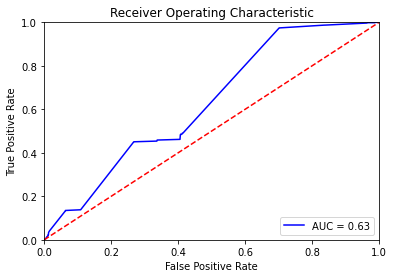

In [53]:
print('Random with StandardScaler')
print('Training Set')
print(confusion_matrix(y_true=y_train, y_pred=y_hat_train))
print(f'Accuracy: {accuracy_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print(f'Precision: {precision_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print(f'Recall: {recall_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print(f'F1-score: {f1_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print('')
print('Validation Set')
print(confusion_matrix(y_true=y_valid, y_pred=y_hat_valid))
print(f'Accuracy: {accuracy_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print(f'Precision: {precision_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print(f'Recall: {recall_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print(f'F1-score: {f1_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print('\nTest Set')
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_hat_test):.3f}')
print(f'Precision: {precision_score(y_true=y_test, y_pred=y_hat_test):.3f}')
print(f'Recall: {recall_score(y_true=y_test, y_pred=y_hat_test):.3f}')
print(f'F1-score: {f1_score(y_true=y_test, y_pred=y_hat_test):.3f}')
plot_roc_auc(y_test, model.predict_proba(X_test)[:,1])

In [60]:
def RandomForestC(X_train,X_test,y_train,y_test,n_estimators=10,max_depth=None,criterion='gini',n_jobs=-1):
    model= RandomForestClassifier(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  n_jobs=n_jobs,
                                 criterion = criterion
                                 )
    model.fit(X_train,y_train.ravel())
    score = model.score(X_test,y_test.ravel())
    return(model,score)

In [61]:
kf=KFold(n_splits=20,random_state=True,shuffle=True)
scorelist =[]
for train_index,test_index in kf.split(X):
    X_train, X_test, y_train, y_test = X.iloc[train_index],X.iloc[test_index],y.iloc[train_index], y.iloc[test_index]
    model,score = RandomForestC(X_train,X_test, y_train ,y_test)
    scorelist.append(score)
    print("Accuracy:" ,score)
print("avg score:", np.mean(scorelist))

Accuracy: 0.9954932230181953
Accuracy: 0.9955941210103252
Accuracy: 0.9960649783069317
Accuracy: 0.9958966769810306
Accuracy: 0.995560339028656
Accuracy: 0.9953921700524687
Accuracy: 0.9960648459572178
Accuracy: 0.9955939728238935
Accuracy: 0.9962666487286426
Accuracy: 0.9956948742096058
Accuracy: 0.9952240010762814
Accuracy: 0.99630028252388
Accuracy: 0.9953585362572313
Accuracy: 0.9958630431857931
Accuracy: 0.9955939728238935
Accuracy: 0.9962666487286426
Accuracy: 0.9954594376429436
Accuracy: 0.9955267052334186
Accuracy: 0.9957957755953182
Accuracy: 0.9954930714381811
avg score: 0.9957251662311275
